In [24]:
import random

import hydra
import numpy as np
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, DDIMScheduler
from diffusers.optimization import get_scheduler
from einops import rearrange
from im2flow2act.flow_generation.AnimateFlow3D import AnimateFlow3D
from im2flow2act.flow_generation.AnimateFlow3DPipeline import AnimationFlow3DPipeline

In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
device = "cuda:0"
import os
dev_dir = os.environ['DEV_PATH']
print(dev_dir)
print(torch.cuda.device_count())

/home/yuanhong/Documents/im2Flow2Act
1


In [44]:
from im2flow2act.flow_generation.dataloader.animateflow_mimicgen_3d_dataset import AnimateFlowMimicgen3DDataset

data_path = "/data/yuanhong/mimicgen_data/core_datasets/coffee/demo_src_coffee_task_D1/demo_3d.hdf5"
dataset = AnimateFlowMimicgen3DDataset(data_path=data_path)
print(dataset[0]["point_tracking_sequence"].shape) # (T, num_points, 3)

Data loaded from /data/yuanhong/mimicgen_data/core_datasets/coffee/demo_src_coffee_task_D1/demo_3d.hdf5
torch.Size([50, 30, 3])


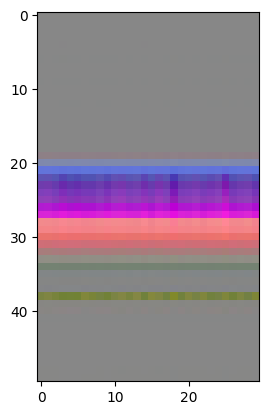

In [28]:
from matplotlib import pyplot as plt

arr = dataset[0]["point_tracking_sequence"].numpy()
scaled_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

# Visualize with imshow
plt.imshow(scaled_arr, cmap='viridis')
plt.show()

In [32]:
from diffusers import UNet2DConditionModel

noise_scheduler_config = {
    'num_train_timesteps': 1000, 
    'beta_start': 0.00085, 
    'beta_end': 0.012, 
    'beta_schedule': 'linear', 
    'steps_offset': 1, 
    'clip_sample': False
}

scheduler = DDIMScheduler(**noise_scheduler_config)

unet = UNet2DConditionModel(in_channels=3, out_channels=3)
model = AnimateFlow3D(unet=unet)

model.to(device)
pipeline = AnimationFlow3DPipeline(model, device, scheduler)

In [43]:
dataset[50]["first_frame_object_points"].shape

torch.Size([30, 6])

In [49]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=3)
batch = next(iter(train_dataloader))

global_obs = batch["global_obs"].to(
    dtype=torch.float32
)
first_frame_object_points = batch["first_frame_object_points"].to(
    dtype=torch.float32
)
# Convert flows to latent space
point_tracking_sequence = batch["point_tracking_sequence"].to(
    dtype=torch.float32
)
# global_obs, first_frame_object_points = dataset[0:2]["global_obs"].to(torch.float32), dataset[0:2]["first_frame_object_points"].to(torch.float32)
# flow = pipeline(global_obs, first_frame_object_points, (50, 30))

In [55]:

# global_obs, first_frame_object_points = dataset[0:2]["global_obs"].to(torch.float32), dataset[0:2]["first_frame_object_points"].to(torch.float32)
flow = pipeline(global_obs, first_frame_object_points, (50, 30))

50it [00:14,  3.36it/s]


In [11]:
batch["point_tracking_sequence"].shape

torch.Size([3, 50, 30, 3])